Missing packages detected: scikit-learn
Installing missing packages...🤔


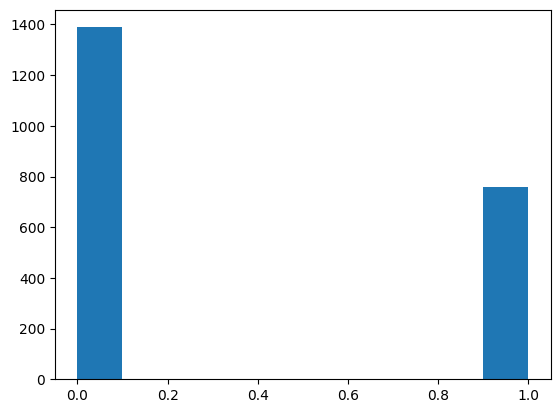

In [7]:
from setup import *
from NeuroPy.firstgraph import *
from NeuroCurveImports import *
#from pre_process import *

def requirements():
    required_packages = get_required_packages()
    missing_packages = [pkg for pkg in required_packages if not is_package_installed(pkg)]
    if missing_packages:
        print(f"Missing packages detected: {', '.join(missing_packages)}")
        print("Installing missing packages...🤔")
        install_requirements()
    else:
        print("All required packages are already installed. 👍")




requirements()
firstgraph()
#print(usableCSV.isna().sum())